/var/folders/y5/yhh2lj4d5pqfmj880n0dd8180000gn/T/ipykernel_46097/3633269635.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('turbo', 10)


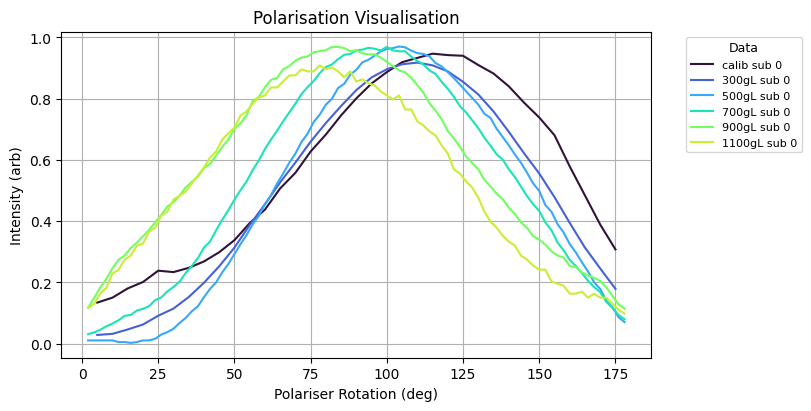

specific rotation: 25.29411764705881 deg dm^-1 g/mL^-1


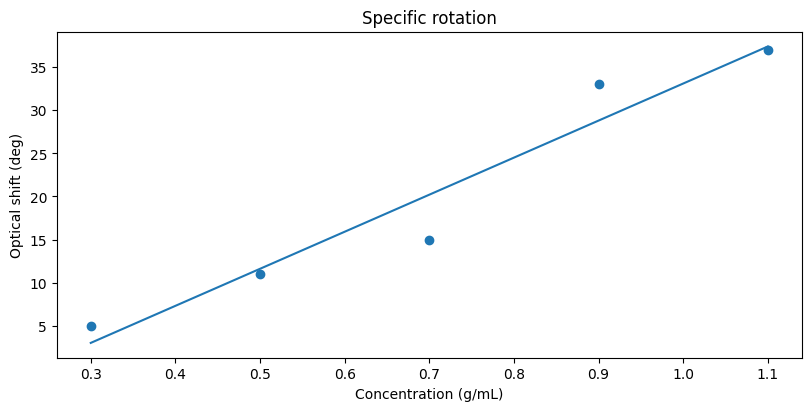

In [81]:
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
from matplotlib import patches

MODE_OV = 0
MODE_CI = 1
MODE_NEW = 2
MODE_ELL = 3

def read_data(path):
    df = pd.read_csv(path, comment='#')
    #df = pd.read_csv('../dat/GREEN/808nm_calib.csv', comment='#')
    # err data angles
    
    angle_deg = df.iloc[:, 0].values
    angle_rad = np.deg2rad(angle_deg)  # 0 to pi
    
    intensities = df.iloc[:, 1:].values
    intensities_rad = intensities.T

    return angle_rad, intensities_rad

def movav(y, window_size=9):
    return np.convolve(y, np.ones(window_size)/window_size, mode='same')

def do_plot_normal(angle_rad, intensities_rad, fix, ax, cmap, title, offset = False):
    global RAND_INDEX
    intensities_rad = intensities_rad / np.nanmax(intensities_rad)

    i = 0
    for y_intensity in intensities_rad:
        angl = math.pi * (1.0/180.0) * float(i) * 10.0
        inten = (y_intensity / 1.0) #/ np.nanmax(y_intensity))
        xs = angle_rad * (180.0 / math.pi)
        ys = inten   
        if offset:
            max_idx = np.argmax(ys)
            ys_rot = np.roll(ys, -max_idx)
            xs_shifted = (xs - xs[max_idx]) % 180
            sorted_idx = np.argsort(xs_shifted)
            xs = xs_shifted[sorted_idx]
            ys = ys_rot[sorted_idx]
        ys = movav(ys)
        ax.plot(xs, ys, label = title + " sub " +str(i*10), color=cmap(RAND_INDEX))
        RAND_INDEX = RAND_INDEX + 1   
        i = i + 1

def do_plot_concen(angle_rad, intensities_rad, fix, ax, cmap, title, gL):
    global RAND_INDEX
    global DIF_FROM_MAX
    intensities_rad = intensities_rad / np.nanmax(intensities_rad)
    
    i = 0
    for y_intensity in intensities_rad:
        angl = math.pi * (1.0/180.0) * float(i) * 10.0
        inten = (y_intensity / 1.0) #/ np.nanmax(y_intensity))
        xs = angle_rad * (180.0 / math.pi)
        ys = movav(inten)
        ax.plot(xs, ys, label = title + " sub " +str(i*10), color=cmap(RAND_INDEX))
        DIF_FROM_MAX.append([xs[np.nanargmax(ys)], gL])
        RAND_INDEX = RAND_INDEX + 1   
        i = i + 1


def plot_concens(PATH_LEN, folder, names):
    fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
    cmap = plt.cm.get_cmap('turbo', 10)
    ax.set(
        xlabel='Polariser Rotation (deg)',
        ylabel='Intensity (arb)',
        title='Polarisation Visualisation'
    )
    for n in names:
        angle_rad, i_rad = read_data("/users/lucas/desktop/physics/year 3/dissert 1/dat/" + folder + n[0] + ".csv")
        do_plot_concen(angle_rad, i_rad, fig, ax, cmap, n[0], n[1])
    xs = []
    ys = []
    for i in range(1, len(DIF_FROM_MAX)):
        shift_deg = np.abs((DIF_FROM_MAX[i][0] - DIF_FROM_MAX[0][0]))
        xs.append(float(DIF_FROM_MAX[i][1]) * 1e-3) # concentration in g/mL
        ys.append(shift_deg) # shift in deg
    ax.grid(True)
    ax.legend(
        title="Data",
        bbox_to_anchor=(1.05, 1), loc='upper left',
        fontsize=8, title_fontsize=9
    )
    plt.show()
    return np.array(xs), np.array(ys)

# path length in dm
PATH_LEN = 17e-1
RAND_INDEX = 0
DIF_FROM_MAX = []
xs1, ys1 = plot_concens(PATH_LEN, "sugar2/red-633/", [["calib", 0], ["300gL", 300], ["500gL", 500], ["700gL", 700], ["900gL", 900], ["1100gL", 1100]])
#xs1, ys1 = plot_concens(PATH_LEN, "sugar2/blue-405/", [["calib", 0], ["300gL", 300], ["500gL", 500], ["700gL", 700], ["900gL-err", 900]])

fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
ax.scatter(xs1, ys1)
ax.plot(np.unique(xs1), np.poly1d(np.polyfit(xs1, ys1, 1))(np.unique(xs1)))
ax.set(xlabel="Concentration (g/mL)", ylabel="Optical shift (deg)",title="Specific rotation")

print("specific rotation: " + str(np.polyfit(xs1, ys1, 1)[0] / PATH_LEN) + " deg dm^-1 g/mL^-1") # 1.7dm

